# INDRA Test Notebook
This notebook contains a simple INDRA workflow designed to test the spectrum of INDRA's capabilities and it's integration with Eidos.

In [1]:
%matplotlib inline

In [2]:
import json
import numpy as np

import pandas

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [10, 8]

from pysb.simulator import ScipyOdeSimulator

from indra.sources import eidos
from IPython.display import Image

from indra.assemblers.graph import GraphAssembler
from indra.assemblers.cag import CAGAssembler
from indra.assemblers.pysb import PysbAssembler

We can define arbitrary text then process it with Eidos:

In [4]:
text = """A significant increase in precipitation resulted in food insecurity and
a decrease in humanitarian interventions. Actually, food insecurity itself can
lead to conflict, and in turn, conflict can drive food insecurity.
Generally, humanitarian interventions reduce conflict."""

ep = eidos.process_text(text)

[{'@type': 'Provenance', 'document': {'@id': '_:Document_1', 'title': 'default_file_name'}, 'documentCharInterval': [{'@type': 'Interval', 'start': 183, 'end': 216}], 'sentence': {'@id': '_:Sentence_2'}, 'positions': [{'@type': 'Interval', 'start': 15, 'end': 19}]}]
[{'@type': 'Provenance', 'document': {'@id': '_:Document_1', 'title': 'default_file_name'}, 'documentCharInterval': [{'@type': 'Interval', 'start': 27, 'end': 112}], 'sentence': {'@id': '_:Sentence_1'}, 'positions': [{'@type': 'Interval', 'start': 5, 'end': 15}]}]
[{'@type': 'Provenance', 'document': {'@id': '_:Document_1', 'title': 'default_file_name'}, 'documentCharInterval': [{'@type': 'Interval', 'start': 27, 'end': 67}], 'sentence': {'@id': '_:Sentence_1'}, 'positions': [{'@type': 'Interval', 'start': 5, 'end': 9}]}]
[{'@type': 'Provenance', 'document': {'@id': '_:Document_1', 'title': 'default_file_name'}, 'documentCharInterval': [{'@type': 'Interval', 'start': 125, 'end': 167}], 'sentence': {'@id': '_:Sentence_2'}, '

We can inspect the Eidos output with:

In [5]:
ep.statements

[Influence(conflict(), food insecurity()),
 Influence(precipitation(positive), humanitarian interventions(negative)),
 Influence(precipitation(positive), food insecurity()),
 Influence(food insecurity(), conflict()),
 Influence(humanitarian interventions(), conflict(negative))]

Next we can use the Eidos statements to assemble a graph demonstrating the relationships Eidos identified:

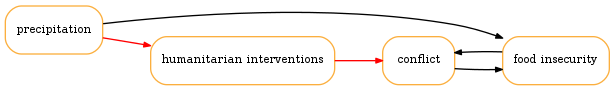

In [6]:
ga = GraphAssembler(ep.statements)
ga.make_model()
ga.save_pdf('text_to_model.png')
Image('text_to_model.png', width=800)

We can define functions which run model simulations using [PySB's ScipyOdeSimulator](https://pysb.readthedocs.io/en/stable/modules/simulator.html#pysb.simulator.ScipyOdeSimulator).

In [7]:
def assemble_pysb(stmts, reverse_effects=True):
    pa = PysbAssembler()
    pa.add_statements(stmts)
    model = pa.make_model(reverse_effects=reverse_effects)
    return model

def simulate_model(model, ts=None, pd=None):
    if not ts:
        ts = np.linspace(0, 1000, 100)
        sim = ScipyOdeSimulator(model, ts)
    if not pd:
        res = sim.run()
    else:
        res = sim.run(param_values=pd)
    df = res.dataframe
    df = df.rename(columns={'__s%d' % i: s.monomer_patterns[0].monomer.name
                                   for i, s in enumerate(model.species)})
    return df

Next we can generate a model and run a simulation. Note the required parameter, `pd`: see [https://pysb.readthedocs.io/en/stable/modules/simulator.html#pysb.simulator.ScipyOdeSimulator](https://pysb.readthedocs.io/en/stable/modules/simulator.html#pysb.simulator.ScipyOdeSimulator) for details on the simulator parameter values. 


```
Values to use for every parameter in the model. Ordering is determined by the order of model.parameters. If passed as a dictionary, keys must be parameter names. If not specified, parameter values will be taken directly from model.parameters.
```

  tree = Parsing.p_module(s, pxd, full_module_name)



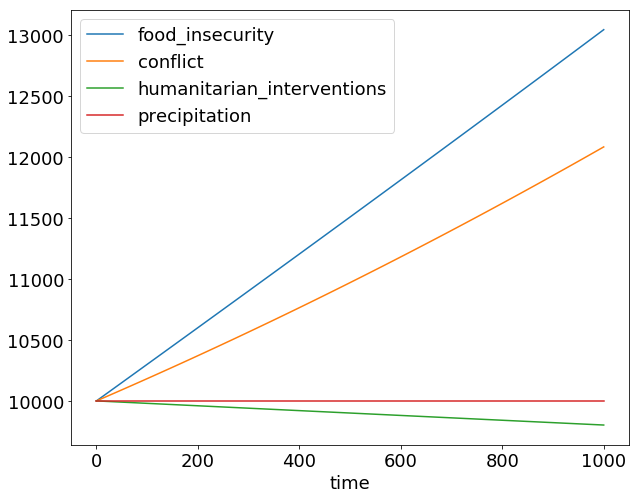

In [8]:
model = assemble_pysb(ep.statements, True)
df = simulate_model(model, ts=None, pd={'kf_f_deg_1': 1e-4})
df.plot()

You can inspect the model parameters with:

In [9]:
model.parameters

ComponentSet([
 Parameter('kf_cf_synth_1', 0.0002),
 Parameter('kf_ph_deg_1', 2e-09),
 Parameter('kf_pf_synth_1', 0.0002),
 Parameter('kf_fc_synth_1', 0.0002),
 Parameter('kf_hc_deg_1', 2e-09),
 Parameter('kf_f_deg_1', 2e-05),
 Parameter('food_insecurity_0', 10000.0),
 Parameter('conflict_0', 10000.0),
 Parameter('humanitarian_interventions_0', 10000.0),
 Parameter('precipitation_0', 10000.0),
 ])

We can adjust the parameters by increasing humanitarian intervention and decreasing precipitation:

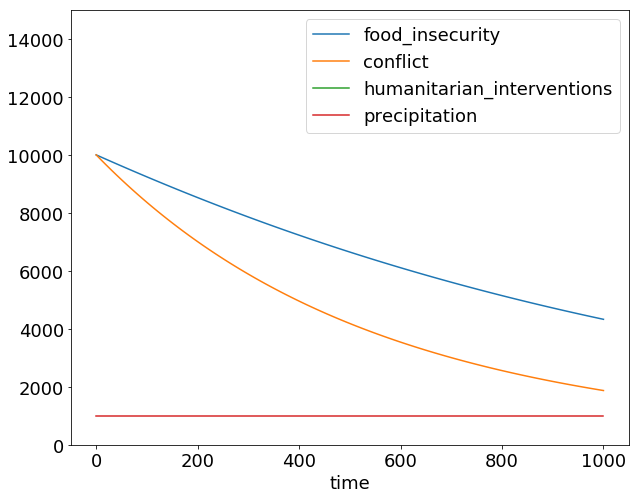

In [12]:
df = simulate_model(model, ts=None, pd={'humanitarian_interventions_0': 1e6, 'precipitation_0': 1e3,
                                        'kf_f_deg_1': 1e-3})

df.plot(ylim=[0, 15000])